In [2]:
"""
This notebook generates the frequency and prom:enhD ratio plots in for profile motif calls using the TF-MoDISco CWMs
(Fig. 2D). For example track and DeepSHAP plots, please see the example tracks directory.
"""

'\nThis notebook generates the frequency and prom:enhD ratio plots in for TF-MoDISco profile (Fig. 2D)\nFor example track and DeepSHAP plots, please see the example tracks directory.\n'

In [1]:
import numpy as np
import h5py
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import pyranges

In [3]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set scratch to where you want to download data to
SCRATCH = "/Users/adamhe/github/scratch"

URL = "https://zenodo.org/records/10597358/files"
TAR = "profile_annotated_seqlets.bed.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")

# Download cCRE data from ENCODE:
print(f"wget https://downloads.wenglab.org/cCREs/GRCh38-PLS.bed -P {SCRATCH}")
print(f"wget https://downloads.wenglab.org/cCREs/GRCh38-ELS.bed -P {SCRATCH}")

wget https://zenodo.org/records/10597358/files/profile_annotated_seqlets.bed.gz -P /Users/adamhe/github/scratch
wget https://downloads.wenglab.org/cCREs/GRCh38-PLS.bed -P /Users/adamhe/github/scratch
wget https://downloads.wenglab.org/cCREs/GRCh38-ELS.bed -P /Users/adamhe/github/scratch


In [63]:
# LOAD DATA

# Get promoter and enhancer
prom_bed = pyranges.read_bed(str(Path(SCRATCH, "GRCh38-PLS.bed")))
enh_bed = pyranges.read_bed(str(Path(SCRATCH, "GRCh38-ELS.bed")))
# Read in windows around PRO-cap peaks in LCLs
all_bed = pd.read_csv(
    str(Path(SCRATCH, "tfmodisco_results/merged_windows_all.bed.gz")),
    sep="\t", header=None, names=["Chromosome", "Start", "End"]
)
all_bed.reset_index(inplace=True)
# Filter ENCODE cCREs for those active in LCLs
active_prom_bed = prom_bed.overlap(pyranges.PyRanges(all_bed))
active_enh_bed = enh_bed.overlap(pyranges.PyRanges(all_bed))
# Load the motif calls
hits = pd.read_csv(
    os.path.join(SCRATCH, "profile_annotated_seqlets.bed.gz"), sep="\t", header=None,
    names=["Chromosome", "Start", "End", "peak_idx", "motif"]
)

In [124]:
# Get motif counts
motif_beds = {
    prefix: pyranges.PyRanges(hits[hits.motif.str.startswith(prefix)])
    for prefix in [motif.split("-")[0] for motif in hits.motif.unique()]
}
motif_counts = {
    prefix: len(motif_beds[prefix]) for prefix in motif_beds.keys()
}
dedup_motif_counts = {
    prefix: len(motif_beds[prefix].as_df().iloc[:, :3].drop_duplicates()) for prefix in motif_beds.keys()
}
prom_motif_counts = {
    prefix: len(motif_beds[prefix].overlap(active_prom_bed).as_df().iloc[:, :3].drop_duplicates())
    for prefix in motif_beds.keys()
}
enh_motif_counts = {
    prefix: len(motif_beds[prefix].overlap(active_enh_bed).as_df().iloc[:, :3].drop_duplicates())
    for prefix in motif_beds.keys()
}
# Get promoter/enhancer ratio
prom_enh_ratio = np.log2(
    (pd.Series(prom_motif_counts) / len(active_prom_bed)) / (pd.Series(enh_motif_counts) / len(active_enh_bed))
)

df = pd.DataFrame([pd.Series(motif_counts), prom_enh_ratio]).T.sort_values(0, ascending=False)

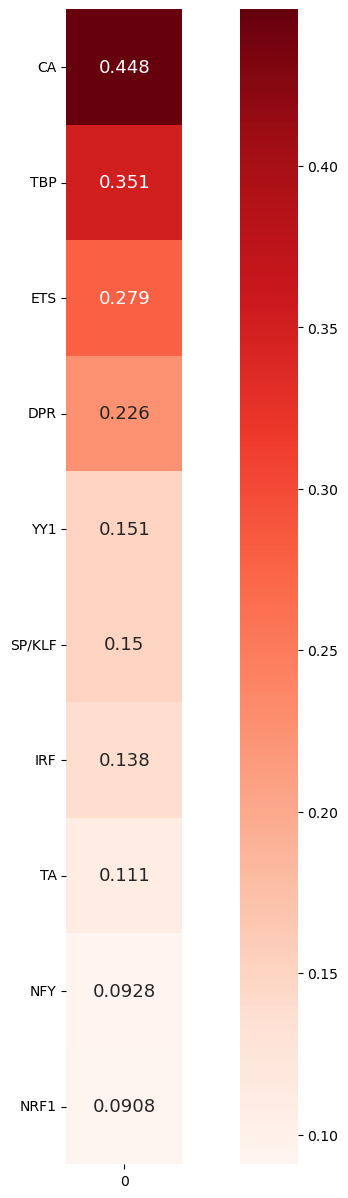

In [133]:
# Plot motif frequency

fig = plt.figure(figsize=(15, 15))
sns.heatmap(
    df.iloc[:, :1] / len(all_bed),
    annot=True,
    annot_kws={"size": 13},
    cmap="Reds",
    fmt=".3",
    square=True,
    #cbar=False,
    #norm=colors.TwoSlopeNorm(0)
)
plt.yticks(rotation=0) 
plt.savefig("img/profile_motif_counts_plot.pdf")

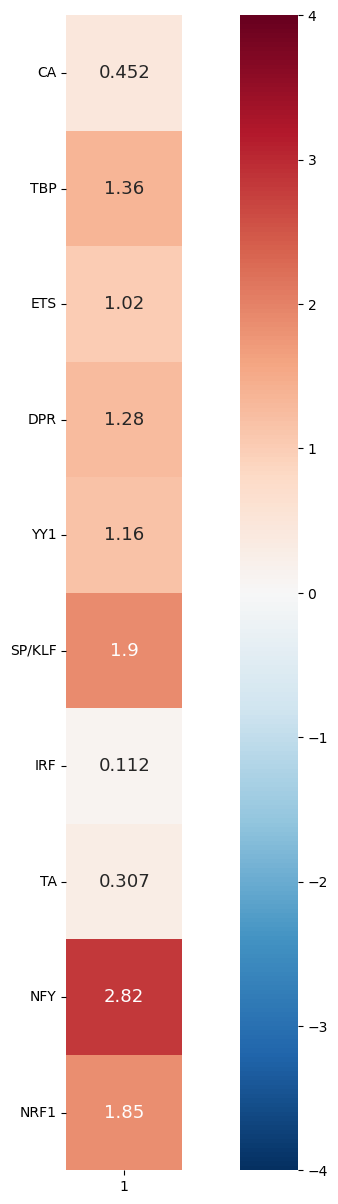

In [132]:
# Plot log10(prom/enhD)

fig = plt.figure(figsize=(15, 15))
sns.heatmap(
    df.iloc[:, 1:],
    annot=True,
    annot_kws={"size": 13},
    fmt=".3",
    square=True,
    cmap="RdBu_r",
    norm=colors.Normalize(-4, 4)
)
plt.yticks(rotation=0) 
plt.savefig("img/profile_prom2enh_plot.pdf")